<a href="https://colab.research.google.com/github/Vijay1C/Movie_Recomendation/blob/main/MovieLens_RS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Download The dataset

In [ ]:
# link to download: https://www.kaggle.com/grouplens/movielens-20m-dataset
# Over 20 Million Movie Ratings and Tagging
path = "/content/drive/MyDrive/Colab Notebooks/RecomenderSystem_MovieLens/MovieLens_Data/"
movies = pd.read_csv(path+"movie.csv")
tags = pd.read_csv(path+"tag.csv")
ratings = pd.read_csv(path+"rating.csv")

### Data Preprocessing EDA

In [ ]:
# Let's peek into the loaded Pandas DataFrame for ratings
print('Sneak peek into the ratings DataFrame:\n\n', ratings.head(), '\n')
print('Number of ratings: ', ratings.shape[0])
print('Number of users who rated at least one movie: ', ratings['userId'].nunique())
print('Number of movies with at least one rating: ', ratings['movieId'].nunique())
print('Max rating: ', ratings['rating'].max(), ' Min rating: ', ratings['rating'].min())

Sneak peek into the ratings DataFrame:

    userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40 

Number of ratings:  20000263
Number of users who rated at least one movie:  138493
Number of movies with at least one rating:  26744
Max rating:  5.0  Min rating:  0.5


In [ ]:
# Now let's peek into the loaded Pandas DataFrame for movies
print('Sneak peek into the movies DataFrame:\n\n', movies.head(2), '\n')
print('Number of movies with at least one rating: ', ratings['movieId'].nunique())
print('Number of movies: ', movies['movieId'].nunique(), ' - notice this is higher than the number of rated movies!')


Sneak peek into the movies DataFrame:

    movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy 

Number of movies with at least one rating:  26744
Number of movies:  27278  - notice this is higher than the number of rated movies!


In [ ]:
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
interaction_mat_size = n_users*n_movies
print(f'user_item_matrix size: {n_users} users  *  {n_movies} movies = {interaction_mat_size/(1e9):.2f} Billion Entries!\t-Very Huge Data')
interaction_count = ratings.shape[0]
sparsity = 1 - (interaction_count / interaction_mat_size)
print(f'Dataset sparsity: {sparsity:.5f} \t-Very Sparse Data')


user_item_matrix size: 138493 users  *  26744 movies = 3.70 Billion Entries!	-Very Huge Data
Dataset sparsity: 0.99460 	-Very Sparse Data


In [ ]:
# The actual user-item matrix has ~3.7B entries (26k movies X 138k users)
# Create a subset of the user/item matrix and take a look

top_users = ratings.groupby('userId')['rating'].count().sort_values(ascending=False)[:10]
top_movies = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)[:10]
ratings_subset = ratings.join(top_users, how='inner', on='userId', rsuffix='_r').join(top_movies, how='inner', on='movieId', rsuffix='_r')

pd.crosstab(ratings_subset.userId, ratings_subset.movieId, ratings_subset.rating, aggfunc=sum)

movieId,110,260,296,318,356,480,527,589,593,2571
userId,,,,,,,,,,
8405,4.0,5.0,5.0,4.5,4.5,4.0,5.0,5.0,5.0,5.0
34576,4.0,4.0,4.5,4.0,3.5,4.0,4.0,4.0,4.5,4.0
59477,4.5,4.0,5.0,4.5,4.0,4.0,4.5,5.0,3.5,3.5
74142,3.0,5.0,5.0,5.0,2.0,2.5,5.0,3.0,2.0,5.0
82418,1.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0
83090,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,5.0
118205,5.0,4.0,4.5,4.0,4.0,3.0,4.0,4.0,4.0,4.0
121535,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.5,4.0
125794,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [ ]:
# Create a new DataFrame
ratings_expanded = pd.merge(ratings, movies, on="movieId")

In [ ]:
ratings_expanded.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995),Adventure|Children|Fantasy


In [ ]:
# Let's create a new DataFrame with additional information
ratings_expanded = pd.merge(ratings, movies, on="movieId")
ratings_stats = pd.DataFrame(ratings_expanded.groupby("title").mean()['rating'])
ratings_stats['rating_count'] = pd.DataFrame(ratings_expanded.groupby("title").count()["rating"])
ratings_stats.sort_values(by='rating_count', ascending=False)

,rating,rating_count
title,,
Pulp Fiction (1994),4.174231,67310
Forrest Gump (1994),4.029000,66172
"Shawshank Redemption, The (1994)",4.446990,63366
"Silence of the Lambs, The (1991)",4.177057,63299
Jurassic Park (1993),3.664741,59715
...,...,...
The Hatchet Man (1932),3.500000,1
The Harry Hill Movie (2013),2.500000,1
The Harmony Game (2011),4.000000,1


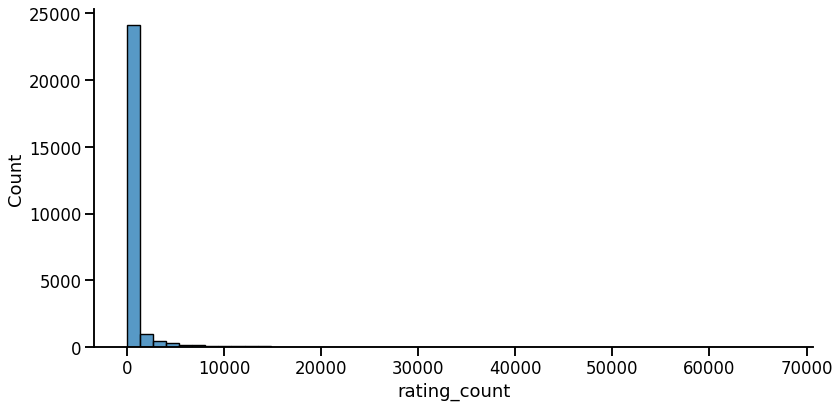

In [ ]:
# Let's view  histogra m of number of ratings - we can see majority of movies have just a few ratings!
import seaborn as sns
sns.set_context("talk")
sns.displot(data=ratings_stats, x="rating_count", bins=50, height=6, aspect=2)

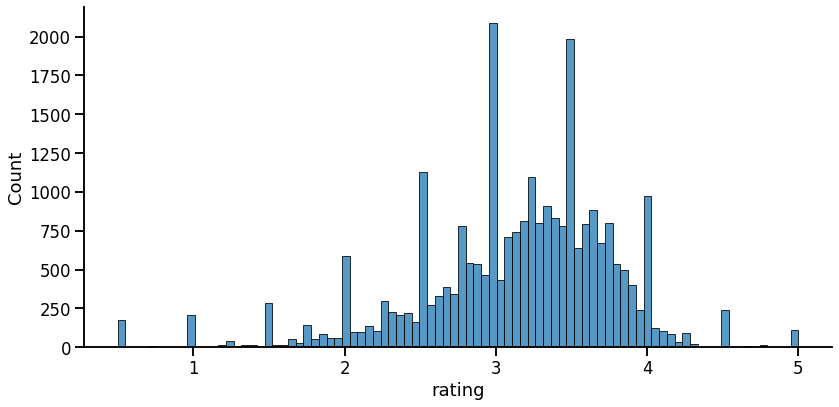

In [ ]:
# Let's check out the rating histogram
sns.displot(data=ratings_stats, x="rating", height=6, aspect=2)


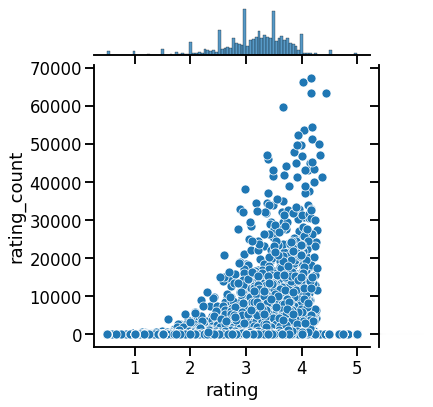

In [ ]:
# Let's look at the relationship between ratings and ratings count.
sns.jointplot(data=ratings_stats, x='rating',y='rating_count')

# This suggests a few things:
# (a) Movies with higher ratings tend to be rated more often
# (b) Extreme ratings (both high and low) tend to have just few ratings

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


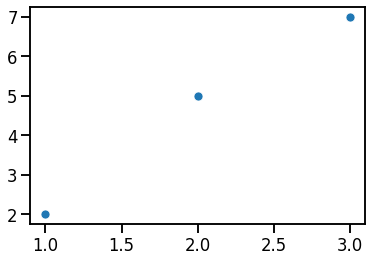

In [ ]:
sns.scatterplot([1,2,3],[2,5,7])

### Feature Engineering

In [ ]:
user_n = len(ratings.userId.unique())
movie_n= len(ratings.movieId.unique())
print("unique users: ", user_n)
print("unique movies: ", movie_n)
print("Total no of entry in user_item matrix: {} Billion entries".format(user_n*movie_n/1000000000))

unique users:  138493
unique movies:  26744
Total no of entry in user_item matrix: 3.703856792 Billion entries


This is a huge dataset of **3.7B entries**!!!!!!, so we need to reduce user and movies otherwise our system may crash.... 



In [ ]:
# Reducing user
# Taking only those users who have seen more than 500 movies

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 500)
print('user % retained: ',len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100)
print('Total no of users after reduction: ', len(ratings_f.userId.unique()))

user % retained:  5.40893763583719
Total no of users after reduction:  7491


In [ ]:
# Reducing movies
# Taking only those movies which have been seen by more than 500 users

ratings_f = ratings_f.groupby('movieId').filter(lambda x: len(x) >= 500)
print("movies % retained: ",len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100)
print('Total no of movies after reduction: ', len(ratings_f.movieId.unique()))

movies % retained:  11.503775936652247
Total no of movies after reduction:  3138


In [ ]:
# Filter the movie dataFrame 
movies = movies[movies.movieId.isin(ratings_f.movieId.tolist())]

 **Content based Filtering** : converting each movie to a feature vecter, using the contents present in each movie

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# We can use 'genres' as one of the feature for featurization
# Convert genres into standard form
movies['genres'] = movies['genres'].str.replace('|',' ')
movies.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


Is there any other features of the movie which we can use for featurization

In [ ]:
tags.head(2)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18


Users have also given a tag for movies, so we can use this information

In [ ]:
# Create a mixed dataFrame of movies containing genres and tags 
movie_genre_tag = pd.merge(movies, tags, on='movieId', how='left')
movie_genre_tag.head(3)


,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched,2014-12-04 23:44:40
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation,2007-07-08 13:59:15
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature,2007-07-08 22:21:47


we can use genres and tags as a feature for each movie, and each movie can be represented by a feature vector for content based filtering

Now doing some **Data Cleaning**

In [ ]:
movie_genre_tag.isnull().sum()

movieId     0
title       0
genres      0
tag         0
metadata    0
dtype: int64

In [ ]:
# Here tags contains some null/NA value, remove them
movie_genre_tag.fillna("", inplace=True)

In [ ]:
# In movie_genre_tag, for each movieId there are multiple tags, so combine them

movie_genre_tag = pd.DataFrame(movie_genre_tag.groupby('movieId')['tag'].apply(lambda x: '%s' % ' '.join(x)))
movie_genre_tag = pd.merge(movies, movie_genre_tag, on='movieId', how='left')
movie_genre_tag.head(2)

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...


In [ ]:
# genres and tags both contains text data, so combine them into one feature

movie_genre_tag['metadata'] = movie_genre_tag[['genres', 'tag']].apply(lambda x:' '.join(x), axis=1)
movie_genre_tag.head(2)

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...,Adventure Animation Children Comedy Fantasy Wa...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...,Adventure Children Fantasy time travel adapted...


In [ ]:
# drop unnecessary features

final_movie_content = movie_genre_tag.drop(['genres', 'tag'], axis=1)
final_movie_content.head() 

,movieId,title,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy Wa...
1,2,Jumanji (1995),Adventure Children Fantasy time travel adapted...
2,3,Grumpier Old Men (1995),Comedy Romance old people that is actually fun...
3,4,Waiting to Exhale (1995),Comedy Drama Romance chick flick revenge chara...
4,5,Father of the Bride Part II (1995),Comedy Diane Keaton family sequel Steve Martin...


In [ ]:
final_movie_content.shape

(3138, 3)

**NLP:** for text data processing

Using **tf-idf** for converting text data to vector form

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(final_movie_content['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=final_movie_content.index.tolist())
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14989,14990,14991,14992,14993,14994,14995,14996,14997,14998
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Dimensionaly of dataset is very large**, so we need to do dimensionality reduction

**SVD:** for dimensionality reduction

In [ ]:
# dimensionality reduction using SVD

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
latent_matrix = svd.fit_transform(tfidf_df)

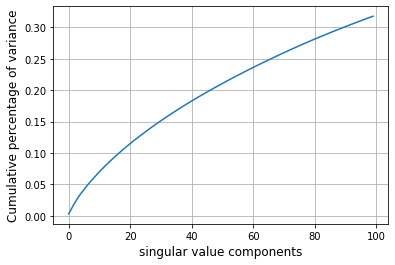

In [ ]:
# Plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained)
plt.xlabel('singular value components', fontsize=12)
plt.ylabel('Cumulative percentage of variance', fontsize=12)
plt.grid()
plt.show()


## 52% variance is expalined using only 400 dimensions

In [ ]:
# Our Final content Matrix:
latent_matrix_1_df = pd.DataFrame(latent_matrix, index=movies.title.tolist())
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Toy Story (1995),0.180040,-0.029725,0.179472,0.465421,-0.246487,-0.058495,0.024107,-0.125411,0.078751,0.013530,...,-0.142771,0.046520,-0.004789,-0.054108,0.012965,-0.035116,-0.003939,0.138220,-0.034207,0.036801
Jumanji (1995),0.141094,-0.039406,0.135554,0.068271,-0.009736,-0.009319,-0.008082,0.023138,-0.066244,0.039775,...,0.028283,-0.000609,-0.021464,0.068854,-0.010630,-0.012650,0.090844,-0.029883,0.024906,-0.008330
Grumpier Old Men (1995),0.066663,-0.027621,-0.033628,0.038321,0.050458,0.014053,0.015012,-0.019165,-0.032388,-0.001640,...,-0.050911,-0.032729,0.011663,-0.021547,-0.018080,-0.017325,-0.027278,0.000322,0.001367,-0.045203
Waiting to Exhale (1995),0.126630,-0.021250,-0.087340,0.072919,0.070705,0.023032,0.021045,-0.000569,-0.093009,0.035726,...,0.044069,-0.001064,-0.052196,-0.064634,0.025935,-0.011279,0.103157,-0.031517,0.032634,0.014046
Father of the Bride Part II (1995),0.130024,-0.046663,-0.058977,0.092092,0.077515,0.020375,0.033131,-0.006297,-0.046430,0.003527,...,-0.012707,-0.023064,-0.063752,0.047507,-0.016179,-0.080003,-0.026129,-0.035314,-0.049314,0.027005


In [ ]:
latent_matrix_1_df.shape

(3138, 100)

 **###############Saving the content matrix to drive**

In [ ]:
latent_matrix_1_df.to_csv(path+"content_matrix.csv")

 **Collaborative Filtering:** Using user ratings to create **item-item based** collaborative filtering Recomendation System

In [ ]:
ratings_f.head()

,userId,movieId,rating,timestamp
960,11,1,4.5,2009-01-02 01:13:41
961,11,10,2.5,2009-01-02 01:15:59
962,11,19,3.5,2009-01-01 04:21:44
963,11,32,5.0,2009-01-01 04:11:35
964,11,39,4.5,2009-01-02 01:17:12


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Creating user-item matrix

movie_user_mat = ratings_f.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat.head()

userId,11,24,54,58,91,104,116,134,156,208,...,138270,138301,138307,138325,138382,138397,138406,138411,138437,138474
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.5,4.0,4.0,5.0,4.0,0.0,3.0,4.0,5.0,4.0,...,0.0,2.5,3.5,5.0,3.0,0.0,4.0,5.0,4.0,5.0
2,0.0,0.0,3.0,0.0,3.5,0.0,2.0,0.0,5.0,0.0,...,0.0,2.5,2.5,3.0,4.0,0.0,3.0,0.0,0.0,4.0
3,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
5,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


**Dimensionaly of dataset is very large**, so we need to do dimensionality reduction

**SVD:** for dimensionality reduction

In [ ]:
# dimensionality reduction using SVD

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
latent_matrix_2 = svd.fit_transform(movie_user_mat)

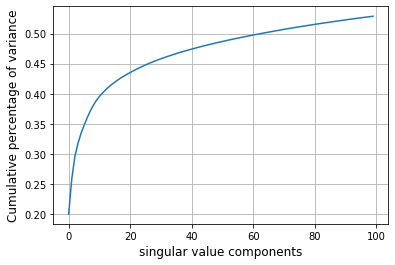

In [ ]:
# Plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained)
plt.xlabel('singular value components', fontsize=12)
plt.ylabel('Cumulative percentage of variance', fontsize=12)
plt.grid()
plt.show()


## 52% variance is expalined using only 400 dimensions

In [ ]:
# Our Final item-user Matrix:
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=movies.title.tolist())
latent_matrix_2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Toy Story (1995),282.536686,6.816792,-18.585359,-9.663804,-10.364832,59.364696,17.815873,-15.457719,0.175333,8.821119,...,2.056949,-3.244911,10.012437,-1.771486,3.283494,-0.306710,6.130810,0.356798,4.032501,6.711264
Jumanji (1995),160.335852,35.603744,-41.767050,-9.981951,-22.336570,27.036077,3.816849,-1.931654,-18.559957,21.741895,...,8.287247,3.756166,3.060842,1.021674,2.475051,-3.800586,3.634932,-0.085365,3.322255,-4.008185
Grumpier Old Men (1995),79.134740,-6.145754,-39.873735,-17.139840,-0.160426,-6.148283,-0.858873,-9.741736,10.495425,20.197650,...,-1.299848,-1.291730,3.577299,0.583457,1.568499,6.384901,-1.862661,0.506830,2.903980,0.347258
Waiting to Exhale (1995),20.404162,-14.381212,-6.370951,-14.540339,1.271769,-4.273144,-3.314943,-9.332595,-9.976461,2.039482,...,-2.409133,2.049181,2.245385,-2.481676,-2.343743,0.424837,-1.450225,-1.156460,1.254442,3.206867
Father of the Bride Part II (1995),65.954870,-2.622380,-33.489965,-31.520951,-2.698947,0.521843,-4.069042,-7.353643,-1.776220,16.673497,...,2.486266,-2.141914,-0.416818,-0.295773,2.698841,-1.444041,-7.053347,-2.963015,4.550577,-0.234358


In [ ]:
latent_matrix_2_df.shape

(3138, 100)

**########### Saving the item-user matrix to drive**

In [ ]:
latent_matrix_2_df.to_csv(path+"item_user_matrix.csv")

 **Running a content, collaborative and Hybrid cosine Similarity**

In [ ]:
# Loading the Trained Model
latent_matrix_1_df = pd.read_csv(path+"content_matrix.csv").set_index('Unnamed: 0')
latent_matrix_2_df = pd.read_csv(path+"item_user_matrix.csv").set_index('Unnamed: 0')

In [ ]:
# Let's create a new DataFrame with popular movies and their ratings
ratings_expanded = pd.merge(ratings_f, movies, on="movieId")
top_movies = pd.DataFrame(ratings_expanded.groupby("title").mean()['rating'])
top_movies['rating_count'] = pd.DataFrame(ratings_expanded.groupby("title").count()["rating"])
top_movies.sort_values(by='rating_count', ascending=False, inplace=True)

In [ ]:
# Defining the function for recomending the movies

from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies(title):

    # Take the latent vectors for a selected movie from both content and collaborative matrix
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # Calculate the similarity of the movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # An average measure of both content and collaborative
    hybrid = (score_1+score_2)/2.0

    # Form a DataFrame of similar movies
    dictDf = {'content-sim': score_1, 'collaborative-sim': score_2, 'hybrid': hybrid}
    similar = pd.DataFrame(dictDf, index=latent_matrix_1_df.index)

    # Sort it on the basis of either: content, collaborative or hybrid
    # Here: hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    return similar.head(11)

**Movies Title:** Sorted by most viewed

In [ ]:
pd.set_option('display.max_rows', None)
top_movies

,rating,rating_count
title,,
"Matrix, The (1999)",4.146633,6980
Forrest Gump (1994),3.844184,6912
Jurassic Park (1993),3.603232,6868
Back to the Future (1985),3.933168,6853
Pulp Fiction (1994),4.256348,6813
"Silence of the Lambs, The (1991)",4.165287,6764
Men in Black (a.k.a. MIB) (1997),3.487776,6749
Star Wars: Episode IV - A New Hope (1977),4.187341,6699
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),4.247453,6674


#


#

#

#

#

**Enter the Movie Title for recomendations**

In [ ]:
recommend_movies("Matrix, The (1999)")

,content-sim,collaborative-sim,hybrid
Unnamed: 0,,,
"Matrix, The (1999)",1.000000,1.000000,1.000000
"Matrix Reloaded, The (2003)",0.940772,0.885513,0.913142
"Matrix Revolutions, The (2003)",0.922761,0.830516,0.876639
Tron (1982),0.773045,0.815149,0.794097
Blade Runner (1982),0.610834,0.923299,0.767067
Strange Days (1995),0.785475,0.736071,0.760773
Johnny Mnemonic (1995),0.745029,0.769340,0.757184
Dark City (1998),0.678780,0.832504,0.755642
"Lawnmower Man, The (1992)",0.760451,0.727044,0.743747


In [ ]:
recommend_movies("Silence of the Lambs, The (1991)")


,content-sim,collaborative-sim,hybrid
Unnamed: 0,,,
"Silence of the Lambs, The (1991)",1.000000,1.000000,1.000000
Hannibal (2001),0.891959,0.806321,0.849140
"Talented Mr. Ripley, The (1999)",0.647448,0.862592,0.755020
Seven (a.k.a. Se7en) (1995),0.523424,0.970198,0.746811
Manhunter (1986),0.851489,0.629952,0.740720
American Psycho (2000),0.641506,0.814730,0.728118
Natural Born Killers (1994),0.590294,0.863818,0.727056
Summer of Sam (1999),0.758035,0.655368,0.706702
Copycat (1995),0.647132,0.758372,0.702752


In [ ]:
recommend_movies("Toy Story (1995)")

,content-sim,collaborative-sim,hybrid
Unnamed: 0,,,
Toy Story (1995),1.000000,1.000000,1.000000
Toy Story 2 (1999),0.982300,0.964849,0.973575
"Bug's Life, A (1998)",0.941880,0.955461,0.948671
"Monsters, Inc. (2001)",0.932126,0.907580,0.919853
Finding Nemo (2003),0.936562,0.881369,0.908965
Ice Age (2002),0.930878,0.808822,0.869850
Antz (1998),0.822517,0.890811,0.856664
"Incredibles, The (2004)",0.847087,0.842546,0.844817
Ratatouille (2007),0.938462,0.685802,0.812132


In [ ]:
recommend_movies("Fight Club (1999)")

,content-sim,collaborative-sim,hybrid
Unnamed: 0,,,
Fight Club (1999),1.000000,1.000000,1.000000
American History X (1998),0.656692,0.956577,0.806634
Seven (a.k.a. Se7en) (1995),0.565797,0.969987,0.767892
Snatch (2000),0.602931,0.930749,0.766840
Memento (2000),0.570057,0.948854,0.759455
Primal Fear (1996),0.724910,0.723122,0.724016
"Sixth Sense, The (1999)",0.451123,0.940513,0.695818
"Illusionist, The (2006)",0.666130,0.712977,0.689553
Being John Malkovich (1999),0.458786,0.919125,0.688955


We can use the similarity information from item-item collaborative filtering to compute a rating prediction ***r[i][u]***, for an ***item(i)*** by a ***user(u)*** where the rating is missing. By taking a weighted average on the ratings of the top K nearest neighbours of item(i) which is already seen by user(u)